In [1]:
# general tools
import os
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import utils
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-12-23 15:56:46.744496: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
#import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [5]:
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    
def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply

def create_model(input_shape=(64, 64, 15)):

    depths=[3, 3, 27, 3]
    projection_dims=[32, 64, 96, 128]
    drop_path_rate=0.0
    layer_scale_init_value=1e-6


    model_name='Branch64X'
    IN64 = layers.Input(shape=input_shape)
    X = IN64

    # X = layers.LocallyConnected2D(32, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
    # X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc1_norm".format(model_name))(X)
    # X = layers.Activation("gelu", name="{}_lc1_gelu".format(model_name))(X)

    # X = layers.LocallyConnected2D(96, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
    # X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc2_norm".format(model_name))(X)
    # X = layers.Activation("gelu", name="{}_lc2_gelu".format(model_name))(X)

    # ----- convnext block 0 ----- #

    X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

    for j in range(depths[0]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                                   groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext


    # ----- convnext block 1 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

    for j in range(depths[1]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                                   groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    # ----- convnext block 2 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

    for j in range(depths[2]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=5, padding="same",
                                   groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    # ----- convnext block 3 ----- #

    X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
    X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

    for j in range(depths[3]):

        X_convnext = X
        X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=5, padding="same",
                                   groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
        X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
        X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
        X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

        X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)
        
        X = keras.layers.Dropout(0.1)(X)
        
        X = X + X_convnext

    V1 = X

    OUT = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
    OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT)

    OUT = layers.Dense(64, name="{}_dense1".format(model_name))(OUT)
    OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
    OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

    OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

    model = Model(inputs=IN64, outputs=OUT, name=model_name)

    return model

In [6]:
def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [7]:
# from importlib import reload
# reload(ck)

In [8]:
#ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
ind_pick_from_batch = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
L_vars = len(ind_pick_from_batch)

In [9]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*neg_neg_neg*.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/TRAIN*pos*.npy"))

filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*neg_neg_neg*.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v3/VALID*pos*.npy"))

print('neg:{} vs pos:{}'.format(len(filename_neg_train), len(filename_pos_train)))

neg:6739773 vs pos:27551


In [21]:
#filename_valid = filename_neg_valid[::600] + filename_pos_valid[::5]
filename_valid = filename_neg_valid[::200] + filename_pos_valid[::50]
print(len(filename_valid))

L_valid = len(filename_valid)

VALID_input_64 = np.empty((L_valid, 64, 64, L_vars))
VALID_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        VALID_input_64[i, ..., k] = data[..., c]

        if 'pos' in name:
            VALID_target[i] = 1.0
        else:
            VALID_target[i] = 0.0

15581


**ConvNext**

In [11]:
#tf.config.list_physical_devices('GPU')

In [13]:
training_rounds = 20

seeds = [78906, 345, 8695]

min_del = 0
max_tol = 1000 # early stopping with patience

epochs = 500
batch_size = 200
L_train = 64 #int(len(TRAIN_Y_pick) / batch_size)

X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch_64[...] = np.nan
Y_batch[...] = np.nan

temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

# =========== Model Section ========== #
key = 'RE0_15p_base'
model_name = '{}_copy3'.format(key)
model_path = temp_dir+model_name

tol = 0

# ========== Training loop ========== #
L_pos = len(filename_pos_train)
L_neg = len(filename_neg_train)

record = 1.1 #0.021237620777840503 #0.05669766786174394 #0.08634155630837792
print("Initial record: {}".format(record))

count = 0


for r in range(training_rounds):
    
    tol = 0 - count - r
    
    #flag_count_change = True
    
    model = create_model(input_shape=(64, 64, 15))
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=2e-4))
    
    # W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE0_15p_base_tune/')
    # model.set_weights(W_old)
    
    set_seeds(seeds[r+1])
    print('Training round {}'.format(r))
    
    for i in range(epochs):
    
        #backend.set_value(model.optimizer.learning_rate, learning_rate[i])
        
        #print('epoch = {}'.format(i))
        start_time = time.time()

        # loop of batch
        for j in range(L_train):
            
            N_pos = 20
            N_neg = batch_size - N_pos
            
            ind_neg = du.shuffle_ind(L_neg)
            ind_pos = du.shuffle_ind(L_pos)
        
            file_pick_neg = []
            for ind_temp in ind_neg[:N_neg]:
                file_pick_neg.append(filename_neg_train[ind_temp])

            file_pick_pos = []
            for ind_temp in ind_pos[:N_pos]:
                file_pick_pos.append(filename_pos_train[ind_temp])
        
            file_pick = file_pick_neg + file_pick_pos
            
            if len(file_pick) != batch_size:
                sregwet
        
            for k in range(batch_size):
                data = np.load(file_pick[k])
                
                for l, c in enumerate(ind_pick_from_batch):
                    temp = data[..., c] 
                    X_batch_64[k, ..., l] = temp
                    
                if 'pos' in file_pick[k]:
                    Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
                elif 'neg_neg_neg' in file_pick[k]:
                    Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
                else:
                    werhgaer
                    
            ind_ = du.shuffle_ind(batch_size)
            X_batch_64 = X_batch_64[ind_, ...]
            Y_batch = Y_batch[ind_, :]
            
            # train on batch
            model.train_on_batch(X_batch_64, Y_batch);
            
        # epoch end operations
        Y_pred = model.predict([VALID_input_64])
        # Y_pred[Y_pred<0] = 0
        # Y_pred[Y_pred>1] = 1
        
        Y_pred = 1/(1 + np.exp(-Y_pred))
        
        record_temp = verif_metric(VALID_target, Y_pred)

        # if i % 10 == 0:
        #     model.save(model_path_backup)

        if (record - record_temp > min_del) and np.max(Y_pred)>0.6:
            print('Validation loss improved from {} to {}'.format(record, record_temp))
            record = record_temp
            tol = 0
            #print('tol: {}'.format(tol))
            # save
            print('save to: {}'.format(model_path))
            model.save(model_path)
        else:
            print('Validation loss {} NOT improved'.format(record_temp))
            if record_temp >= 2.0:
                print('Early stopping')
                break;
            else:
                tol += 1
                if tol >= max_tol:
                    print('Early stopping')
                    break;
                else:
                    if tol == 1 and i > count:
                        #flag_count_change = False
                        count = i
                        print(count)
                    continue;
        print("--- %s seconds ---" % (time.time() - start_time))

Initial record: 1.1
Training round 0
0.08107401697331332
Validation loss improved from 1.1 to 0.08107401697331332
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3/assets
--- 429.4139862060547 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.09843409588137554
Validation loss 0.09843409588137554 NOT improved
1
0.06149379702681327
Validation loss improved from 0.08107401697331332 to 0.06149379702681327
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3/assets
--- 440.64180731773376 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04913106044999709
Validation loss improved from 0.06149379702681327 to 0.04913106044999709
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3/assets
--- 410.1532738208771 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.056176219292635
Validation loss 0.056176219292635 NOT improved
4
0.046016181741484884
Validation loss improved from 0.04913106044999709 to 0.046016181741484884
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3/assets
--- 443.74311208724976 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.05458607790878401
Validation loss 0.05458607790878401 NOT improved
6
0.04980382324936772
Validation loss 0.04980382324936772 NOT improved
0.047081948672200336
Validation loss 0.047081948672200336 NOT improved
0.061679164151976135
Validation loss 0.061679164151976135 NOT improved
0.036704218766266936
Validation loss improved from 0.046016181741484884 to 0.036704218766266936
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3/assets
--- 467.31594944000244 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.036265144287484744
Validation loss improved from 0.036704218766266936 to 0.036265144287484744
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3/assets
--- 477.73267436027527 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.041096528823241836
Validation loss 0.041096528823241836 NOT improved
12
0.03805111180735153
Validation loss 0.03805111180735153 NOT improved
0.04846340206594941
Validation loss 0.04846340206594941 NOT improved
0.044702086363517156
Validation loss 0.044702086363517156 NOT improved
0.0452922545495858
Validation loss 0.0452922545495858 NOT improved
0.052568317558922245
Validation loss 0.052568317558922245 NOT improved
0.04230204165132747
Validation loss 0.04230204165132747 NOT improved
0.06280314990079322
Validation loss 0.06280314990079322 NOT improved
0.04997302799531191
Validation loss 0.04997302799531191 NOT improved
0.04078624106047025
Validation loss 0.04078624106047025 NOT improved
0.04281333675492204
Validation loss 0.04281333675492204 NOT improved
0.043462114872500304
Validation loss 0.043462114872500304 NOT improved
0.03746763536171941
Validation loss 0.03746763536171941 NOT improved
0.03714549368515669
Validation loss 0.03714549368515669 NOT improved
0.038285482782954294
Vali

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04969411588631819
Validation loss 0.04969411588631819 NOT improved
31
0.04449141256207741
Validation loss 0.04449141256207741 NOT improved
0.04071113454230698
Validation loss 0.04071113454230698 NOT improved
0.03674887073533596
Validation loss 0.03674887073533596 NOT improved
0.04452495637061366
Validation loss 0.04452495637061366 NOT improved
0.05140562366570663
Validation loss 0.05140562366570663 NOT improved
0.051759323630552155
Validation loss 0.051759323630552155 NOT improved
0.04011185052649835
Validation loss 0.04011185052649835 NOT improved
0.034411879692131234
Validation loss improved from 0.0352108048063652 to 0.034411879692131234
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3/assets
--- 487.2727553844452 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04118701439765044
Validation loss 0.04118701439765044 NOT improved
40
0.037805977723644656
Validation loss 0.037805977723644656 NOT improved
0.04522280028111232
Validation loss 0.04522280028111232 NOT improved
0.040771510709147106
Validation loss 0.040771510709147106 NOT improved
0.04054344420306813
Validation loss 0.04054344420306813 NOT improved
0.041144892536616684
Validation loss 0.041144892536616684 NOT improved
0.03630107891473997
Validation loss 0.03630107891473997 NOT improved
0.036809644706720525
Validation loss 0.036809644706720525 NOT improved
0.043756373720423895
Validation loss 0.043756373720423895 NOT improved
0.03440441608929702
Validation loss improved from 0.034411879692131234 to 0.03440441608929702
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3/assets
--- 475.8872859477997 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.045030551531604346
Validation loss 0.045030551531604346 NOT improved
50
0.05429358091745911
Validation loss 0.05429358091745911 NOT improved
0.04000598792556312
Validation loss 0.04000598792556312 NOT improved
0.03442978174438201
Validation loss 0.03442978174438201 NOT improved
0.035783025610161535
Validation loss 0.035783025610161535 NOT improved
0.05200499628211065
Validation loss 0.05200499628211065 NOT improved
0.048950727660047225
Validation loss 0.048950727660047225 NOT improved
0.038206231638370745
Validation loss 0.038206231638370745 NOT improved
0.037397729233578994
Validation loss 0.037397729233578994 NOT improved
0.04414349411105546
Validation loss 0.04414349411105546 NOT improved
0.035015874411123644
Validation loss 0.035015874411123644 NOT improved
0.0484337512855153
Validation loss 0.0484337512855153 NOT improved
0.04170855504903565
Validation loss 0.04170855504903565 NOT improved
0.03904998267986236
Validation loss 0.03904998267986236 NOT improved
0.03821947073540426
V

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04281396648638103
Validation loss 0.04281396648638103 NOT improved
69
0.04743547393578026
Validation loss 0.04743547393578026 NOT improved
0.0422829735444662
Validation loss 0.0422829735444662 NOT improved
0.036547100781097346
Validation loss 0.036547100781097346 NOT improved
0.04160911646730463
Validation loss 0.04160911646730463 NOT improved
0.04694593324877254
Validation loss 0.04694593324877254 NOT improved
0.043009405718064754
Validation loss 0.043009405718064754 NOT improved
0.042568928070402245
Validation loss 0.042568928070402245 NOT improved
0.03993487327396657
Validation loss 0.03993487327396657 NOT improved
0.03969661567288497
Validation loss 0.03969661567288497 NOT improved
0.03798984276297975
Validation loss 0.03798984276297975 NOT improved
0.04108086573764183
Validation loss 0.04108086573764183 NOT improved
0.043911781351485754
Validation loss 0.043911781351485754 NOT improved
0.04203115145392362
Validation loss 0.04203115145392362 NOT improved
0.03910020390902617
Valid

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04292992160927262
Validation loss 0.04292992160927262 NOT improved
96
0.04103883276946228
Validation loss 0.04103883276946228 NOT improved
0.042411106346271675
Validation loss 0.042411106346271675 NOT improved
0.041132817438375525
Validation loss 0.041132817438375525 NOT improved
0.032374179386407534
Validation loss improved from 0.03412245141474898 to 0.032374179386407534
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3/assets
--- 479.068710565567 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03456720833020091
Validation loss 0.03456720833020091 NOT improved
101
0.035269653854966505
Validation loss 0.035269653854966505 NOT improved
0.03649196722557012
Validation loss 0.03649196722557012 NOT improved
0.039758909716709666
Validation loss 0.039758909716709666 NOT improved
0.030346190229867887
Validation loss improved from 0.032374179386407534 to 0.030346190229867887
save to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/RE0_15p_base_copy3/assets
--- 468.24379205703735 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03410567315627303
Validation loss 0.03410567315627303 NOT improved
106
0.04403620483357523
Validation loss 0.04403620483357523 NOT improved
0.03824593725825922
Validation loss 0.03824593725825922 NOT improved
0.04546951525834534
Validation loss 0.04546951525834534 NOT improved
0.03344787687725001
Validation loss 0.03344787687725001 NOT improved
0.03251348656239833
Validation loss 0.03251348656239833 NOT improved
0.033502660310953
Validation loss 0.033502660310953 NOT improved
0.032499202774698234
Validation loss 0.032499202774698234 NOT improved
0.03391908626250699
Validation loss 0.03391908626250699 NOT improved
0.035216490879527544
Validation loss 0.035216490879527544 NOT improved
0.03422468741188813
Validation loss 0.03422468741188813 NOT improved
0.035674761939560345
Validation loss 0.035674761939560345 NOT improved
0.03438309927112936
Validation loss 0.03438309927112936 NOT improved



KeyboardInterrupt



In [22]:
model = create_model(input_shape=(64, 64, 15))

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=0))

W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/RE0_15p_base_tune2/')
#W_old = k_utils.dummy_loader('/glade/work/ksha/NCAR/Keras_models/FAKE_Lead6_tune3')
model.set_weights(W_old)

In [23]:
Y_pred = model.predict([VALID_input_64])
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1

Y_pred = 1/(1 + np.exp(-Y_pred))

record_temp = verif_metric(VALID_target, Y_pred)

0.02882396175236131


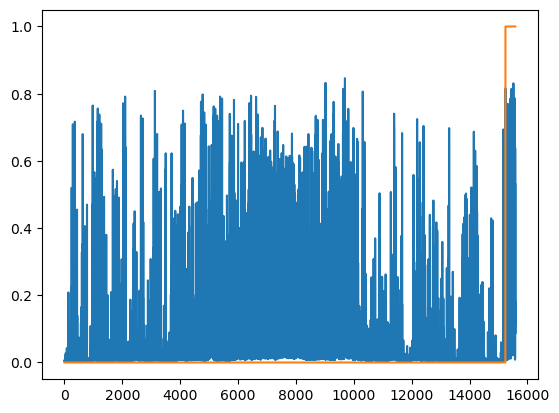

In [24]:
plt.plot(Y_pred)
plt.plot(VALID_target)

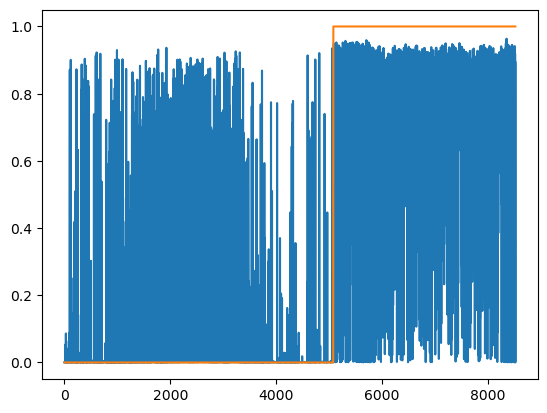

In [14]:
plt.plot(Y_pred)
plt.plot(VALID_target)